##Reading from directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/"

 360TS_Setup_Mini.exe		       movies_complete.csv	   tumor_dataset_contrast
 AP1401-2-HW5-main_Sepehr9923004.zip   original.ipynb		   tumor_dataset_for_model
'Colab Notebooks'		       Scanned_20180528-1528.pdf   tumor_dataset_for_model_adam
 Crop_MRI_data			       Sepehr_kmeans
 ex1data1.txt			       tumor_classification


In [ ]:
image_directory  = "/content/drive/My Drive/tumor_classification"

In [ ]:
classes = !ls "/content/drive/My Drive/tumor_classification"
print(classes[0])

glioma	meningioma  pituitary_tumor


In [ ]:
#create classes ------
classes = classes[0].split()
print(classes)

['glioma', 'meningioma', 'pituitary_tumor']


In [ ]:
glioma = !ls "/content/drive/My Drive/tumor_classification/glioma"
meningioma = !ls "/content/drive/My Drive/tumor_classification/meningioma"
pituitary_tumor = !ls "/content/drive/My Drive/tumor_classification/pituitary_tumor"

In [ ]:
print(glioma)

['100416_1350.png     MR026175C_1993.png\tMR037458C_2726.png  MR048994_2434.png\tMR051461_2917.png', '100416_1351.png     MR026175C_1994.png\tMR037458C_2727.png  MR048994_2435.png\tMR051461_2918.png', '100416_1352.png     MR026175C_1995.png\tMR037458C_2728.png  MR048994_2436.png\tMR051461_2919.png', '100416_1353.png     MR026175C_1996.png\tMR037458C_2729.png  MR048994_2437.png\tMR051461_2920.png', '100820_122.png\t    MR026175C_2325.png\tMR038469_2145.png   MR048994_2438.png\tMR051461_2921.png', '100820_124.png\t    MR026175C_2326.png\tMR038469_2146.png   MR048994_2439.png\tMR051461_2922.png', '100820_1354.png     MR026175C_2327.png\tMR038469_2147.png   MR048994_2440.png\tMR051461_2923.png', '100820_1355.png     MR026175C_2328.png\tMR038469_2148.png   MR048994_2845.png\tMR051461B_2011.png', '100820_1356.png     MR026175C_2329.png\tMR038469_2149.png   MR048994_2846.png\tMR051461B_2012.png', '100820_1357.png     MR026175C_2330.png\tMR038469_2150.png   MR048994_2847.png\tMR051461B_2013.pn

In [ ]:
contents = []
directory_contents = {}
#glioma
for content in glioma:
  c = content.split()
  contents.extend(c)
directory_contents['glioma'] = contents
contents = []

#meningioma
for content in meningioma:
  c = content.split()
  contents.extend(c)
directory_contents['meningioma'] = contents
contents = []

#glioma
for content in pituitary_tumor:
  c = content.split()
  contents.extend(c)
directory_contents['pituitary_tumor'] = contents
contents = []

In [ ]:
print(len(directory_contents['pituitary_tumor']))
print(len(directory_contents['glioma']))
print(len(directory_contents['meningioma']))

930
1426
708


##Data visualization and preprocessing

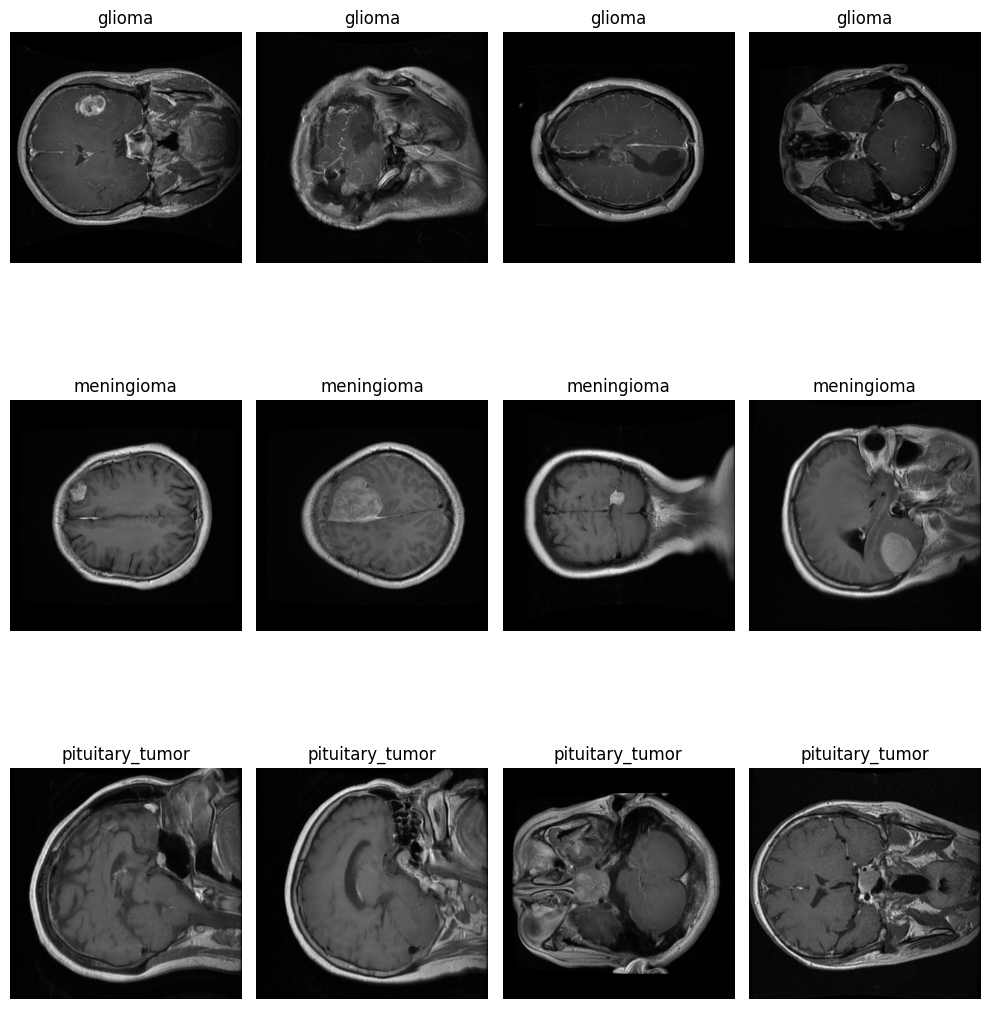

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(3, 4, figsize=(10, 12))
for c in classes:
  random.shuffle(directory_contents[c])
  photos = directory_contents[c][:4]
  for i in range (4):
    path =  image_directory + "/" + c + "/" + photos[i]
    image = mpimg.imread(path)
    if c == "glioma":
      axs[0,i].imshow(image, cmap='gray')
      axs[0,i].axis('off')
      axs[0,i].set_title(c)
    if c == "meningioma":
      axs[1,i].imshow(image, cmap='gray')
      axs[1,i].axis('off')
      axs[1,i].set_title(c)
    if c == "pituitary_tumor":
      axs[2,i].imshow(image, cmap='gray')
      axs[2,i].axis('off')
      axs[2,i].set_title(c)
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
def crop_brain_region(image_path):
    # Read the MRI image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive thresholding to segment the brain region
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Perform morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=5)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=5)

    # Find contours of the brain region
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10000]

    if valid_contours:
        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(valid_contours[0])

        # Crop the image using the bounding box coordinates
        cropped_image = image[y:y+h, x:x+w]
    else:
        cropped_image = None

    return cropped_image


In [ ]:
def apply_clahe(image_path):
    # Read the MRI image
    image = cv2.imread(image_path)

    if len(image.shape) == 2:  # Grayscale image
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
        l, a, b = cv2.split(lab)  # Split into L, A, B channels
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)  # Apply CLAHE to the L channel
        lab_clahe = cv2.merge((l_clahe, a, b))  # Merge the CLAHE-enhanced L channel with A and B
        enhanced_image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)  # Convert back to BGR

    return enhanced_image


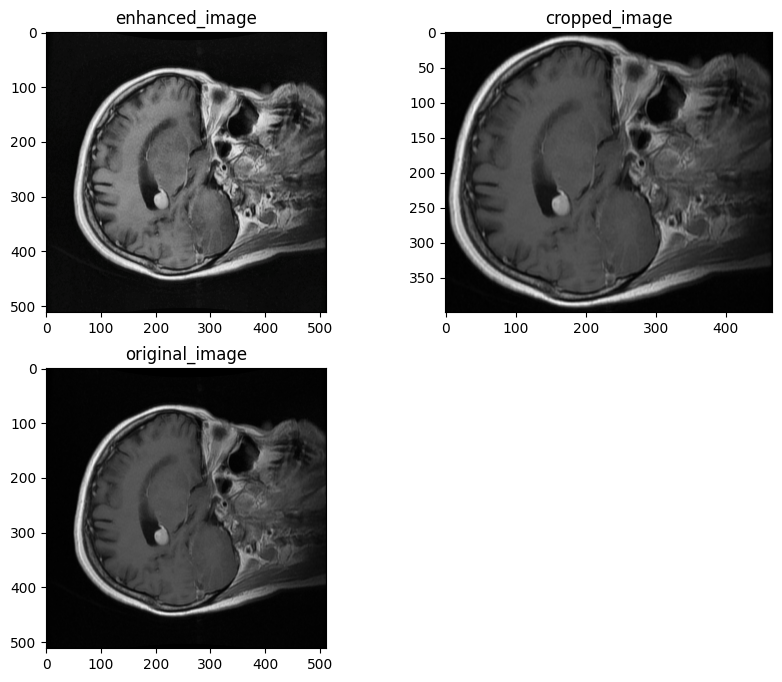

In [ ]:
# Check the crop and enhanced methods
random_file = random.choice(directory_contents['meningioma'])
random_file_path = "/content/drive/My Drive/tumor_classification/meningioma" + "/" + random_file
cropped_image = crop_brain_region(random_file_path)
enhanced_image = apply_clahe(random_file_path)
original_image = cv2.imread(random_file_path)

# Display the photos
plt.figure(figsize = (10,8))
plt.subplot(2,2,1)
plt.imshow(enhanced_image , cmap = 'gray')
plt.title("enhanced_image")
plt.subplot(2,2,2)
plt.imshow(cropped_image , cmap = 'gray')
plt.title("cropped_image")
plt.subplot(2,2,3)
plt.imshow(original_image , cmap = 'gray')
plt.title("original_image")
plt.show()

##Creating test and train directories and data for the model

In [ ]:
import os
import random
output_dir = "/content/drive/MyDrive/tumor_dataset_contrast"
os.makedirs(output_dir, exist_ok=True)

# Create train and test directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Process each class
for class_name in classes:

    class_path = os.path.join(image_directory, class_name)
    images = os.listdir(class_path)
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Shuffle and split into train/validation
    random.shuffle(images)
    split_idx = 500
    train_images = images[:500]
    val_images = images[500:700]

    # Process and copy images to the respective directories
    for img in train_images:
        img_path = os.path.join(class_path, img)
        enhanced = apply_clahe(img_path)
        output_path = os.path.join(train_dir, class_name, img)
        cv2.imwrite(output_path, enhanced)

    for img in val_images:
        img_path = os.path.join(class_path, img)
        enhanced = apply_clahe(img_path)
        output_path = os.path.join(test_dir, class_name, img)
        cv2.imwrite(output_path, enhanced)

In [ ]:
x = !ls "/content/drive/MyDrive/tumor_dataset_contrast/train/meningioma"
print(len(x))

84


In [91]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

train_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (64,64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    target_size = (64,64),
    batch_size=32,
    class_mode='categorical'
)


Found 1503 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


##Building up the deep learning models

In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 411,811 (1.57 MB)

 Trainable params: 411,811 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,379 (364.76 KB)

 Trainable params: 93,379 (364.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model6.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,795 (3.21 MB)

 Trainable params: 841,795 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7 = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model6.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,795 (3.21 MB)

 Trainable params: 841,795 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping2 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint2 = ModelCheckpoint('model2.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history2 = model2.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping2, model_checkpoint2]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.5127 - loss: 0.9395
Epoch 1: val_loss improved from inf to 0.56862, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - accuracy: 0.5286 - loss: 0.9158 - val_accuracy: 0.7667 - val_loss: 0.5686
Epoch 2/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.7398 - loss: 0.5825
Epoch 2: val_loss improved from 0.56862 to 0.39301, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 412ms/step - accuracy: 0.7442 - loss: 0.5747 - val_accuracy: 0.8417 - val_loss: 0.3930
Epoch 3/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.8039 - loss: 0.4460
Epoch 3: val_loss improved from 0.39301 to 0.38046, saving model to model2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.8030 - loss: 0.4477 - val_accuracy: 0.8400 - val_loss: 0.3805
Epoch 4/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.8740 - loss: 0.3382
Epoch 4: val_loss improved from 0.38046 to 0.34139, saving model to model2

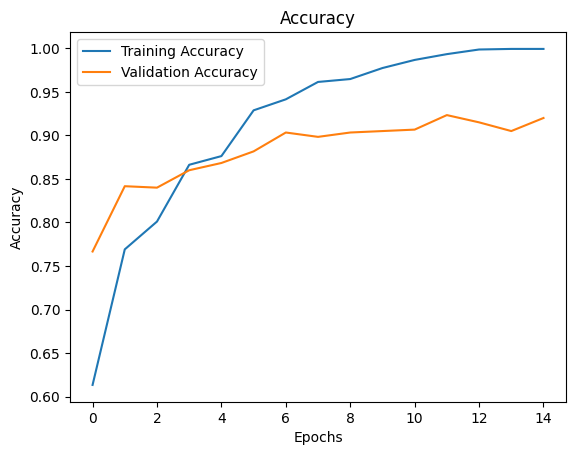

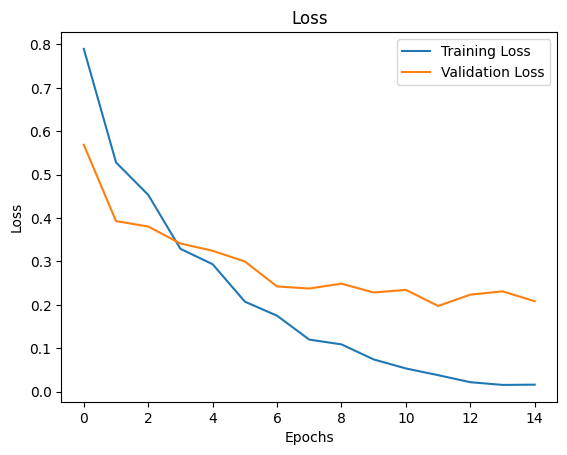

In [89]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step


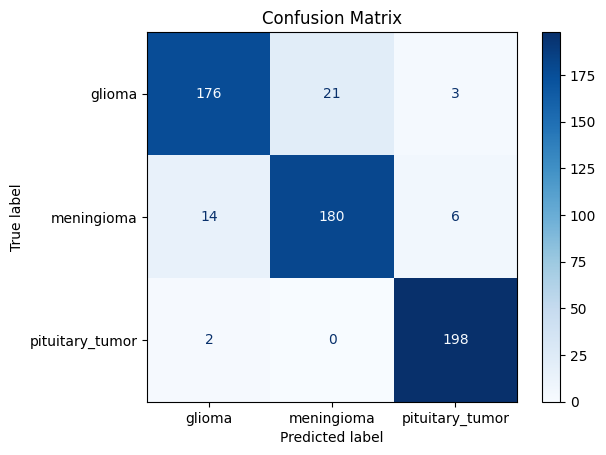

In [92]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping3 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint3 = ModelCheckpoint('model3.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history3 = model3.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping3, model_checkpoint3]
)


Epoch 1/15
39/47 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.4284 - loss: 1.0553
Epoch 1: val_loss improved from inf to 0.66343, saving model to model3.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 438ms/step - accuracy: 0.4456 - loss: 1.0329 - val_accuracy: 0.6550 - val_loss: 0.6634
Epoch 2/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.6565 - loss: 0.6857
Epoch 2: val_loss did not improve from 0.66343
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 397ms/step - accuracy: 0.6614 - loss: 0.6806 - val_accuracy: 0.6567 - val_loss: 0.6784
Epoch 3/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.7100 - loss: 0.5912
Epoch 3: val_loss improved from 0.66343 to 0.63513, saving model to model3.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.7113 - loss: 0.5904 - val_accuracy: 0.7367 - val_loss: 0.6351
Epoch 4/15
40/47 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.7443 - loss: 0.5613
Epoch 4: val_loss improved from 0.63513 to 0.44582, saving model to model3.keras
47/47 ━━━━━━━━━━

In [93]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model3.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.8761 - loss: 0.2806
Test Accuracy: 0.91, Test Loss: 0.22


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step


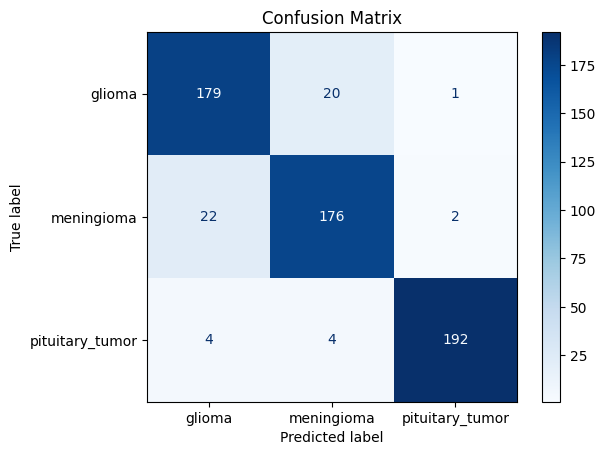

In [95]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

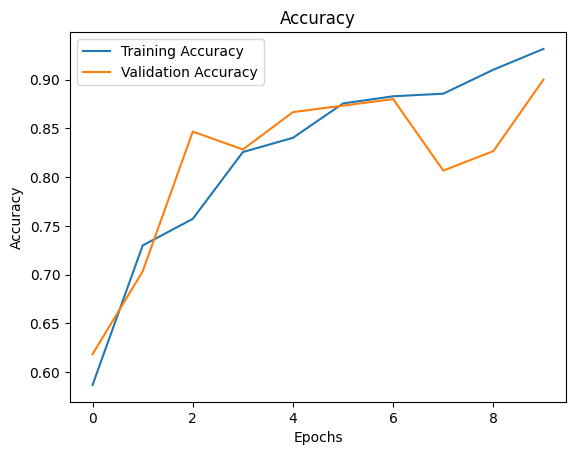

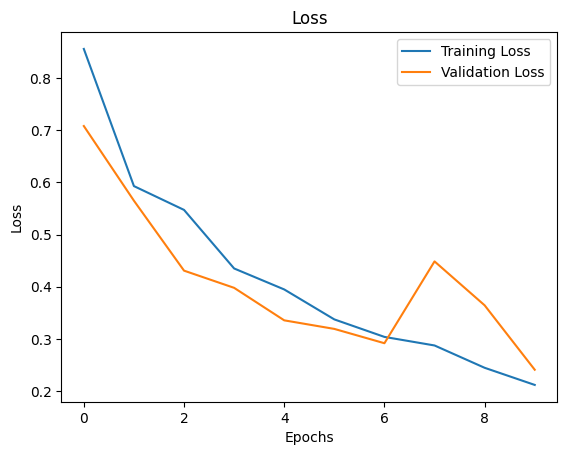

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Compile the model
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping6 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint6 = ModelCheckpoint('model6.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history6 = model6.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping6, model_checkpoint6]
)

Epoch 1/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5611 - loss: 0.9438
Epoch 1: val_loss improved from inf to 0.57208, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 459ms/step - accuracy: 0.5640 - loss: 0.9373 - val_accuracy: 0.7050 - val_loss: 0.5721
Epoch 2/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7616 - loss: 0.5432
Epoch 2: val_loss improved from 0.57208 to 0.56829, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - accuracy: 0.7623 - loss: 0.5425 - val_accuracy: 0.7183 - val_loss: 0.5683
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8095 - loss: 0.4013
Epoch 3: val_loss improved from 0.56829 to 0.32031, saving model to model6.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - accuracy: 0.8098 - loss: 0.4011 - val_accuracy: 0.8750 - val_loss: 0.3203
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9107 - loss: 0.2577
Epoch 4: val_loss improved from 0.32031 to 0.30381, saving mode

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model6.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.9320 - loss: 0.1574
Test Accuracy: 0.93, Test Loss: 0.17


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step


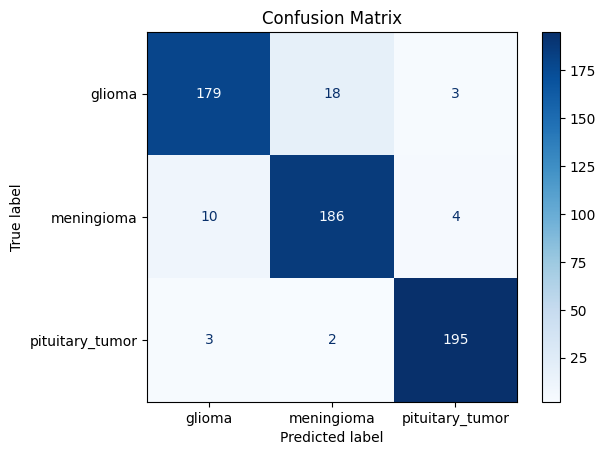

In [96]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model6.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

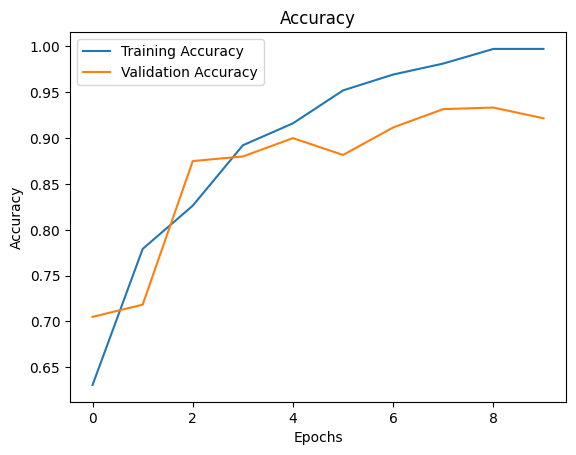

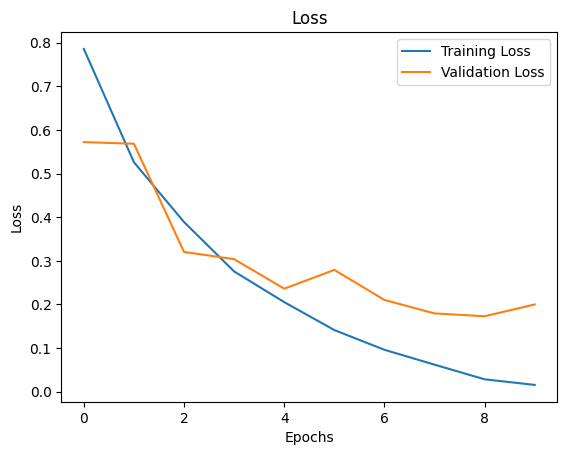

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Compile the model
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping7 = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint7 = ModelCheckpoint('model7.keras', monitor='val_loss', save_best_only=True, mode="auto", verbose=1)

history6 = model7.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping7, model_checkpoint7]
)

Epoch 1/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5548 - loss: 0.9383
Epoch 1: val_loss improved from inf to 0.60297, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 558ms/step - accuracy: 0.5568 - loss: 0.9330 - val_accuracy: 0.7250 - val_loss: 0.6030
Epoch 2/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7210 - loss: 0.5844
Epoch 2: val_loss improved from 0.60297 to 0.47061, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 413ms/step - accuracy: 0.7221 - loss: 0.5831 - val_accuracy: 0.7917 - val_loss: 0.4706
Epoch 3/10
44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8136 - loss: 0.4591
Epoch 3: val_loss improved from 0.47061 to 0.32897, saving model to model7.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 435ms/step - accuracy: 0.8139 - loss: 0.4584 - val_accuracy: 0.8883 - val_loss: 0.3290
Epoch 4/10
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8521 - loss: 0.3385
Epoch 4: val_loss improved from 0.32897 to 0.25705, saving mode

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('model7.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.9330 - loss: 0.1928
Test Accuracy: 0.94, Test Loss: 0.18


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step


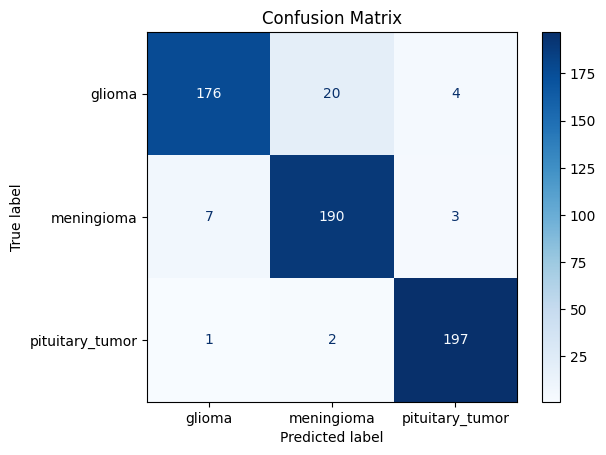

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

predictions = model7.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes , predicted_classes)

#plot---
disp = ConfusionMatrixDisplay(confusion_matrix = cm , display_labels = class_labels)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

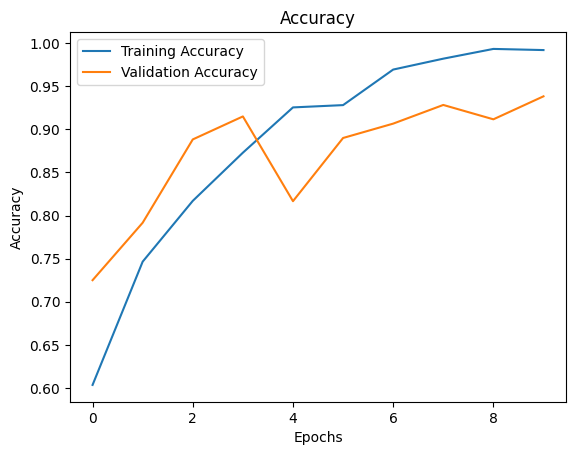

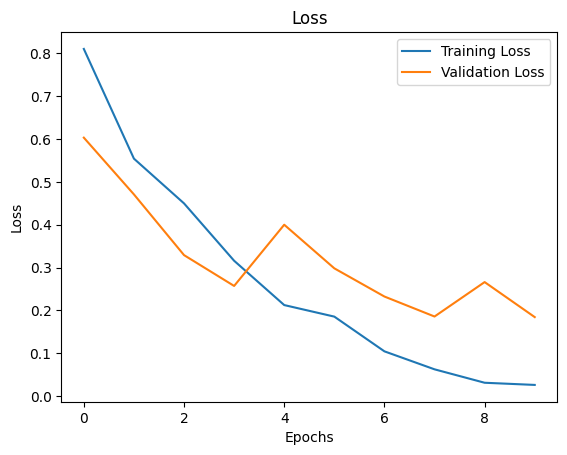

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()